# Assignment 2

In this assignment, you will learn about resampling methods for model evaluation and attribute selection. You have to predict the crime rate based on a large number of different attributes. You can use the SciKit-learn library to fit the linear regressions. The rest of the code has to be programmed from scratch. Be careful not to use the same data for training (any stage of training) and testing your model.

1. Download the "Communities and Crime" dataset and prepare the data so that you will be able to use them for linear regression.
2. Implement the cross-validation method and the leave-one-out method.
3. Implement forward attribute selection. Fit linear regression.
4. Use the attribute selection method with the implemented cross-validation to select a reasonable set of attributes for your linear model.
5. Test your model and report the results.
6. Implement the bootstrap method and apply it to the train set to generate 1000 different train sets and train 1000 different linear models.
7. Use the bootstrapped results to assess the confidence intervals of the results of the linear model.


In [1]:
# Import all dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Data Retrieval


In [2]:
# Download the data from https://archive.ics.uci.edu/dataset/183/communities+and+crime
# Load the data into a pandas dataframe, and remove the first 5 columns (state, county, community, communityname, fold)
with open("./data/communities.names") as file:
    columns = [
        line.split(" ")[1] for line in file.readlines() if line.startswith("@attribute")
    ]
data = pd.read_csv("./data/communities.data", header=None, names=columns, na_values="?")


columns_to_remove = ["state", "county", "community", "communityname", "fold"]
data = data.drop(columns=columns_to_remove)
data

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1990,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1991,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


### Data Analyzing


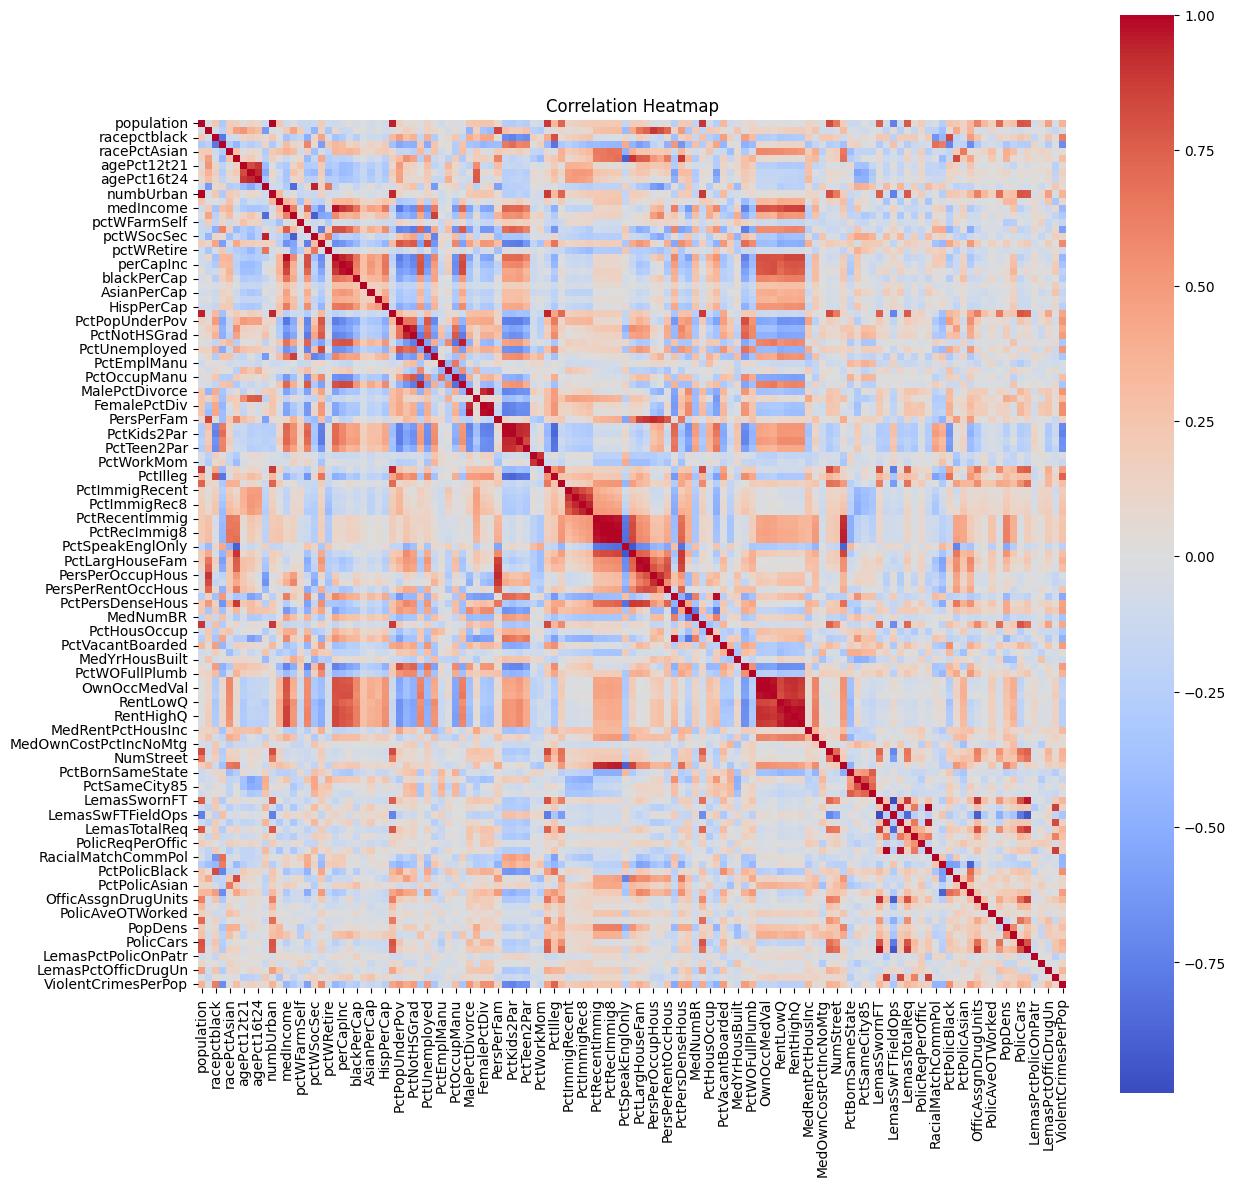

In [3]:
# Exploratory Data Analysis (EDA)
correlation_matrix = data.corr()

_, ax = plt.subplots(1, figsize=(14, 14))
sns.heatmap(
    correlation_matrix,
    square=True,
    cmap="coolwarm",
    ax=ax,
)
plt.title("Correlation Heatmap")
plt.show()

### Data Preprocessing


In [4]:
# Impute the missing values with the mean of the column
# Columns with missing values: LemasPctPolicOnPatr, LemasGangUnitDeploy, PolicBudgPerPop
data = data.fillna(data.mean())

### Data Splitting


In [5]:
# Split the data into training and testing sets (80% training, 20% testing)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### Forward Feature Selection


In [6]:
def kFoldCrossValidation(X, y, model, k=5):
    """
    Perform k-fold cross-validation for a machine learning model.

    Parameters:
    - X: Features
    - y: Target variable
    - model: The machine learning model to be evaluated
    - k: Number of folds for cross-validation

    Returns:
    - average_mse: Average Mean Squared Error over k folds
    """
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Calculate the size of each fold
    fold_size = len(X) // k

    # Initialize a list to store MSE scores for each fold
    mse_scores = []

    # Perform k-fold cross-validation
    for index in range(k):
        # Define the indices for the current fold
        start_index = index * fold_size
        end_index = (index + 1) * fold_size if index < k - 1 else len(X)

        # Split the data into training and testing sets for this fold
        X_train = np.vstack((X[:start_index], X[end_index:]))
        y_train = np.concatenate((y[:start_index], y[end_index:]))
        X_test = X[start_index:end_index]
        y_test = y[start_index:end_index]

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate the Mean Squared Error (MSE) for this fold
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

    # Calculate the average MSE over all folds
    average_mse = np.mean(mse_scores)
    return average_mse


def leaveOneOutCrossValidation(X, y, model):
    """
    Perform leave-one-out cross-validation for a machine learning model.
    Alternatively, you can use kFoldCrossValidation with k = len(X).

    Parameters:
    - X: Features
    - y: Target variable
    - model: The machine learning model to be evaluated

    Returns:
    - average_mse: Average Mean Squared Error over all leave-one-out iterations
    """
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Calculate the number of iterations
    n = len(X)

    # Initialize a list to store MSE scores for each iteration
    mse_scores = []

    # Perform leave-one-out cross-validation
    for index in range(n):
        # Split the data into training and testing sets for this iteration
        X_train = np.delete(X, index, axis=0)
        y_train = np.delete(y, index)
        X_test = X[index : index + 1]
        y_test = [y[index]]

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Make a prediction on the test data
        y_pred = model.predict(X_test)

        # Calculate the Mean Squared Error (MSE) for this iteration
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

    # Calculate the average MSE over all leave-one-out iterations
    average_mse = np.mean(mse_scores)
    return average_mse


def forwardAttributeSelection(
    X, y, k=5, early_stop=True, max_iterations=None, min_improvement=None
):
    """
    Perform forward attribute selection and fit a linear regression model.

    Parameters:
    - X: Features
    - y: Target variable
    - k: Number of folds for cross-validation
    - early_stop: Whether to stop early if the MSE increases
    - max_iterations: Maximum number of iterations (stopping criterion)
    - min_improvement: Minimum improvement in MSE to continue (stopping criterion)

    Returns:
    - attributes: List of selected attributes
    - mse_scores: List of MSE scores for each iteration
    - best_mse: Mean Squared Error of the model using the selected attributes
    """

    # Initialize the selected attributes list and best MSE
    iterations = 0
    attributes = []
    mse_scores = []
    best_mse = float("inf")
    last_mse = float("inf")

    # Create a list of all available attributes
    all_attributes = X.columns.tolist()

    # Perform forward attribute selection
    while len(attributes) < len(all_attributes):
        # Get the non-selected (remaining) attributes
        remaining_attributes = [
            attribute for attribute in all_attributes if attribute not in attributes
        ]
        candidate_mses = []

        # Try adding each remaining attribute to the selected attributes
        for attribute in remaining_attributes:
            selected_attributes = attributes + [attribute]

            # Perform k-fold cross-validation with the selected attributes
            model = LinearRegression()
            average_mse = kFoldCrossValidation(X[selected_attributes], y, model, k)
            candidate_mses.append(average_mse)

        # Find the attribute with the lowest MSE
        attribute_index = np.argmin(candidate_mses)
        attribute = remaining_attributes[attribute_index]
        mse = candidate_mses[attribute_index]

        # Check stopping criteria for max iterations
        if max_iterations is not None and iterations > max_iterations:
            break

        # Check stopping criteria for min improvement
        if min_improvement is not None and abs(last_mse - mse) < min_improvement:
            break

        # Check if the mse has improved
        if mse > last_mse:
            if early_stop:
                break
        else:
            best_mse = mse

        # Add the attribute to the selected attributes list and save the MSE
        attributes.append(attribute)
        mse_scores.append(mse)

        # Print the iteration and the selected attribute with its MSE
        iterations += 1
        print(f"Iteration {iterations}: {attribute} (MSE: {mse})")

        # Update the last MSE
        last_mse = mse

    return attributes, mse_scores, best_mse

In [7]:
# Use 5-fold cross validation to find the best attributes
# k = 5 because we want to use 80% of the data for training, and 20% for testing
attributes, mse_scores, best_mse = forwardAttributeSelection(
    X_train, y_train, k=5, early_stop=True, max_iterations=None, min_improvement=None
)

Iteration 1: PctIlleg (MSE: 0.025185359812691377)
Iteration 2: TotalPctDiv (MSE: 0.02283200821096675)
Iteration 3: HousVacant (MSE: 0.021696843797914856)
Iteration 4: racePctWhite (MSE: 0.020675474475363064)
Iteration 5: PctWorkMom (MSE: 0.02030488138466637)
Iteration 6: PctKids2Par (MSE: 0.02001666907789457)
Iteration 7: pctUrban (MSE: 0.019859868163337038)
Iteration 8: NumStreet (MSE: 0.0197170138200635)
Iteration 9: numbUrban (MSE: 0.019486673364567636)
Iteration 10: PctPolicWhite (MSE: 0.019394617434143245)
Iteration 11: MalePctDivorce (MSE: 0.019307432023776577)
Iteration 12: MedOwnCostPctIncNoMtg (MSE: 0.01922255651324633)
Iteration 13: PctEmplManu (MSE: 0.019183805222169198)
Iteration 14: PctSameCity85 (MSE: 0.01911454773598135)
Iteration 15: pctWRetire (MSE: 0.019057629296444743)
Iteration 16: MedRentPctHousInc (MSE: 0.019013574087070016)
Iteration 17: PctPopUnderPov (MSE: 0.018956158898866083)
Iteration 18: pctWInvInc (MSE: 0.018858120963398034)
Iteration 19: pctWSocSec (MSE: 

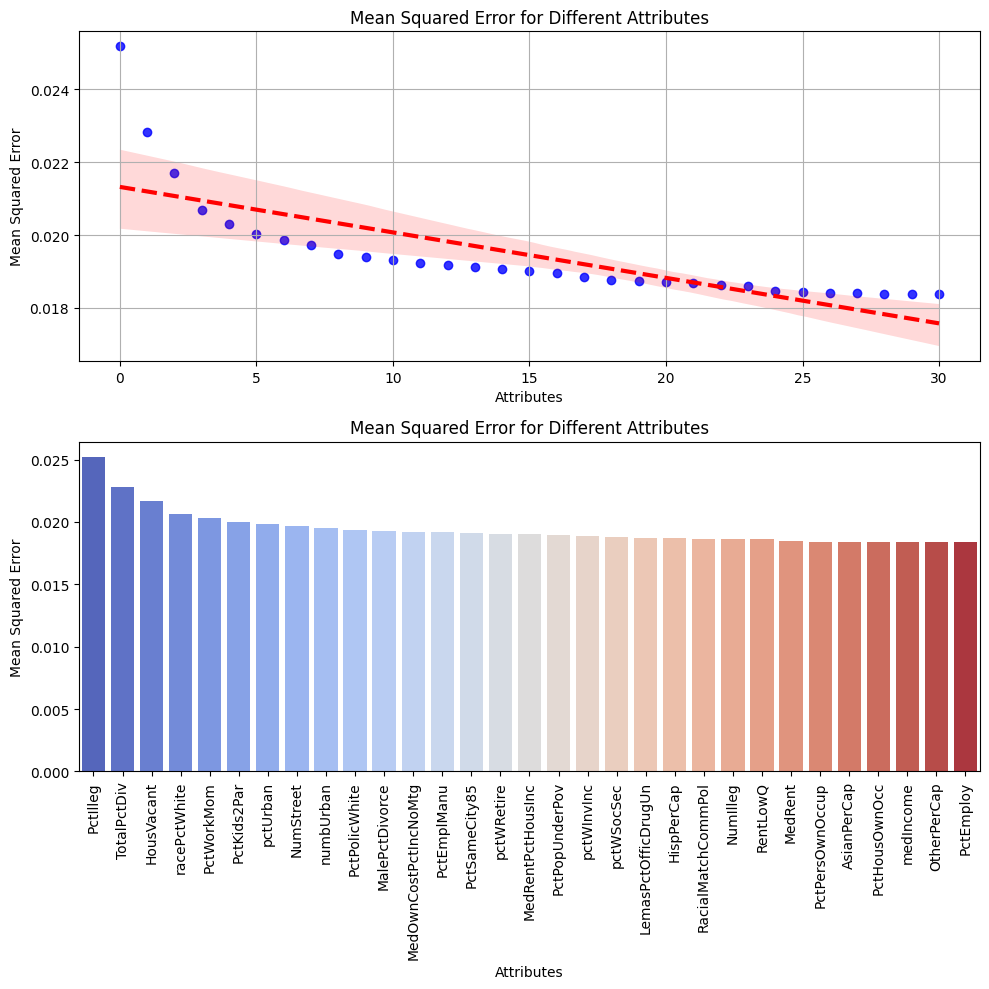

In [8]:
# Create a DataFrame from the attributes and MSE values
data = {"Attributes": attributes, "MSE": mse_scores}
data = pd.DataFrame(data)

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot the MSE values for each attribute
sns.regplot(
    x=np.arange(len(attributes)),
    y="MSE",
    data=data,
    color="blue",
    scatter=True,
    line_kws={"color": "red", "linestyle": "--", "linewidth": 3},
    ax=ax1,
)
ax1.set_title("Mean Squared Error for Different Attributes")
ax1.set_xlabel("Attributes")
ax1.set_ylabel("Mean Squared Error")
ax1.grid(True)

# Plot a bar chart of the MSE values for each attribute
sns.barplot(
    x="Attributes",
    y="MSE",
    data=data,
    palette="coolwarm",
    hue="Attributes",
    legend=False,
    ax=ax2,
)
ax2.set_title("Mean Squared Error for Different Attributes")
ax2.set_xlabel("Attributes")
ax2.set_ylabel("Mean Squared Error")
plt.xticks(rotation=90, axes=ax2)


plt.tight_layout()
plt.show()

### Linear Regression Models


In [9]:
# Build a naive linear regression model using all the attributes
naive_model = LinearRegression()
naive_model.fit(X_train, y_train)

# Predict the values for the test set
naive_y_prediction = naive_model.predict(X_test)

In [10]:
# Use data only for the best attributes
X_train = X_train[attributes]
X_test = X_test[attributes]

# Build a linear regression model using the best attributes
ffs_model = LinearRegression()
ffs_model.fit(X_train, y_train)

# Predict the values for the test set
ffs_y_prediction = ffs_model.predict(X_test)

### Model Evaluation


In [11]:
# Calculate the evaluation metrics for the scikit-learn model
naive_mae = mean_absolute_error(y_test, naive_y_prediction)
naive_mse = mean_squared_error(y_test, naive_y_prediction)
naive_r2 = r2_score(y_test, naive_y_prediction)

# Calculate the evaluation metrics for the custom implementation model
ffs_mae = mean_absolute_error(y_test, ffs_y_prediction)
ffs_mse = mean_squared_error(y_test, ffs_y_prediction)
ffs_r2 = r2_score(y_test, ffs_y_prediction)

### Model Comparison


In [12]:
# Compare the evaluation metrics for both models
print("[naive] Mean Absolute Error:", naive_mae)
print("[naive] Mean Squared Error:", naive_mse)
print("[naive] R-squared:", naive_r2)
print("[ffs] Mean Absolute Error:", ffs_mae)
print("[ffs] Mean Squared Error:", ffs_mse)
print("[ffs] R-squared:", ffs_r2)

[naive] Mean Absolute Error: 0.16729969474659465
[naive] Mean Squared Error: 2.1456989818415035
[naive] R-squared: -43.799363645964064
[ffs] Mean Absolute Error: 0.0941451472245801
[ffs] Mean Squared Error: 0.017820165212195822
[ffs] R-squared: 0.6279384627907283


### Diagnostic Plots


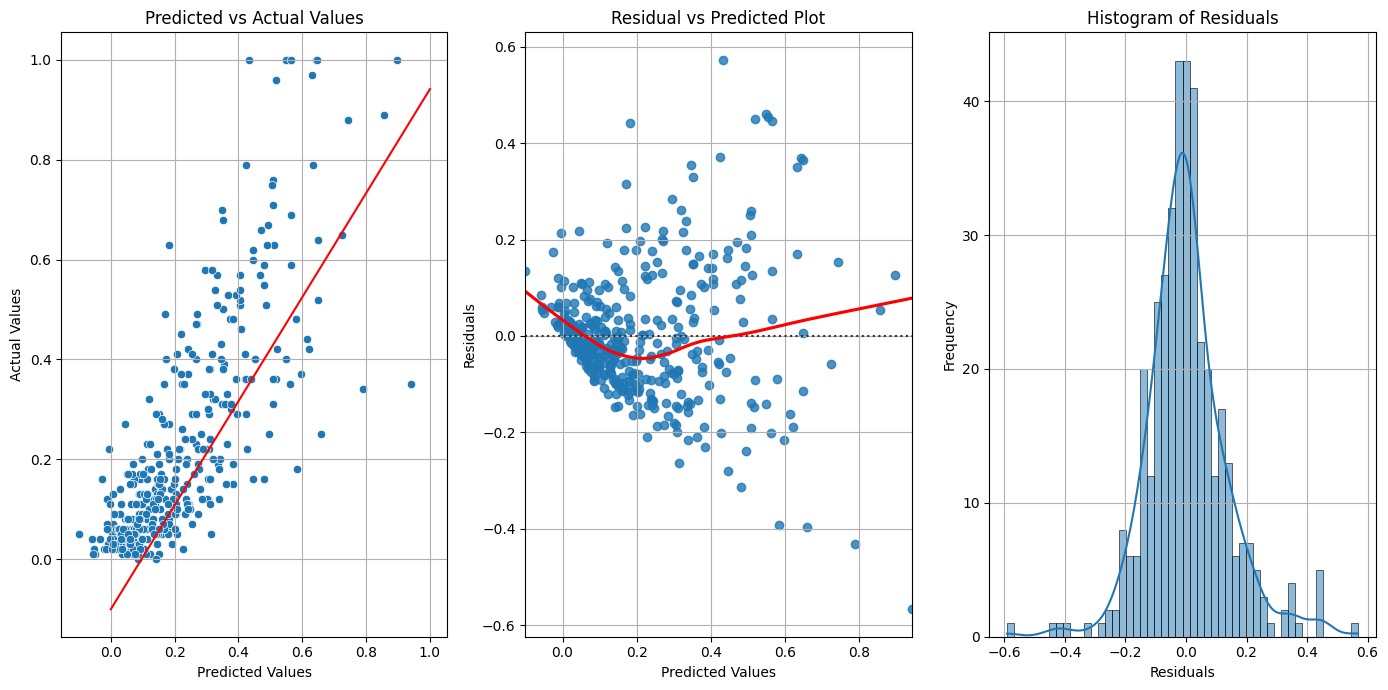

In [13]:
y_prediction = ffs_y_prediction
y_test = y_test

# Calculate the residuals
residuals = y_test - y_prediction

# Build a dataframe with the residuals and the predictions
data = pd.DataFrame(
    {
        "originals": y_test,
        "predictions": y_prediction,
        "residuals": residuals,
    }
)

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 7))

# Plot the predicted values against the actual values
sns.scatterplot(data, x="predictions", y="originals", ax=ax1)
ax1.plot(
    [min(data["originals"]), max(data["originals"])],
    [min(data["predictions"]), max(data["predictions"])],
    color="red",
)
ax1.set_title("Predicted vs Actual Values")
ax1.set_xlabel("Predicted Values")
ax1.set_ylabel("Actual Values")
ax1.grid(True)

# Plot the residuals against the predicted values
sns.residplot(
    data,
    x="predictions",
    y="residuals",
    lowess=True,
    line_kws={"color": "red"},
    ax=ax2,
)
ax2.set_title("Residual vs Predicted Plot")
ax2.set_xlabel("Predicted Values")
ax2.set_ylabel("Residuals")
ax2.grid(True)

# Create a histogram of residuals using Seaborn
sns.histplot(residuals, bins=50, kde=True, ax=ax3)
ax3.set_title("Histogram of Residuals")
ax3.set_xlabel("Residuals")
ax3.set_ylabel("Frequency")
ax3.grid(True)

plt.tight_layout()
plt.show()

### Bootstrap Method


In [14]:
# Define the number of bootstrap samples
num_bootstrap_samples = 1000
mse_scores = []

# Loop through the number of bootstrap samples
for sample in range(num_bootstrap_samples):
    print(f"Progress: {(sample + 1) / num_bootstrap_samples * 100:.1f}%")

    # Randomly sample the data with replacement
    bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X = X_train.iloc[bootstrap_indices]
    y = y_train.iloc[bootstrap_indices]

    # Train a linear regression model on the bootstrap sample
    model = LinearRegression()
    model.fit(X, y)

    # Predict the values for the test set using the trained model and calculate the MSE
    y_prediction = model.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, y_prediction))

# Calculate confidence intervals for the MSE scores
confidence_level = 0.95
alpha = (1 - confidence_level) / 2

# Calculate the lower and upper percentiles
mse_lower_percentile = np.percentile(mse_scores, 100 * alpha)
mse_upper_percentile = np.percentile(mse_scores, 100 * (1 - alpha))

Progress: 0.1%
Progress: 0.2%
Progress: 0.3%
Progress: 0.4%
Progress: 0.5%
Progress: 0.6%
Progress: 0.7%
Progress: 0.8%
Progress: 0.9%
Progress: 1.0%
Progress: 1.1%
Progress: 1.2%
Progress: 1.3%
Progress: 1.4%
Progress: 1.5%
Progress: 1.6%
Progress: 1.7%
Progress: 1.8%
Progress: 1.9%
Progress: 2.0%
Progress: 2.1%
Progress: 2.2%
Progress: 2.3%
Progress: 2.4%
Progress: 2.5%
Progress: 2.6%
Progress: 2.7%
Progress: 2.8%
Progress: 2.9%
Progress: 3.0%
Progress: 3.1%
Progress: 3.2%
Progress: 3.3%
Progress: 3.4%
Progress: 3.5%
Progress: 3.6%
Progress: 3.7%
Progress: 3.8%
Progress: 3.9%
Progress: 4.0%
Progress: 4.1%
Progress: 4.2%
Progress: 4.3%
Progress: 4.4%
Progress: 4.5%
Progress: 4.6%
Progress: 4.7%
Progress: 4.8%
Progress: 4.9%
Progress: 5.0%
Progress: 5.1%
Progress: 5.2%
Progress: 5.3%
Progress: 5.4%
Progress: 5.5%
Progress: 5.6%
Progress: 5.7%
Progress: 5.8%
Progress: 5.9%
Progress: 6.0%
Progress: 6.1%
Progress: 6.2%
Progress: 6.3%
Progress: 6.4%
Progress: 6.5%
Progress: 6.6%
Progress: 

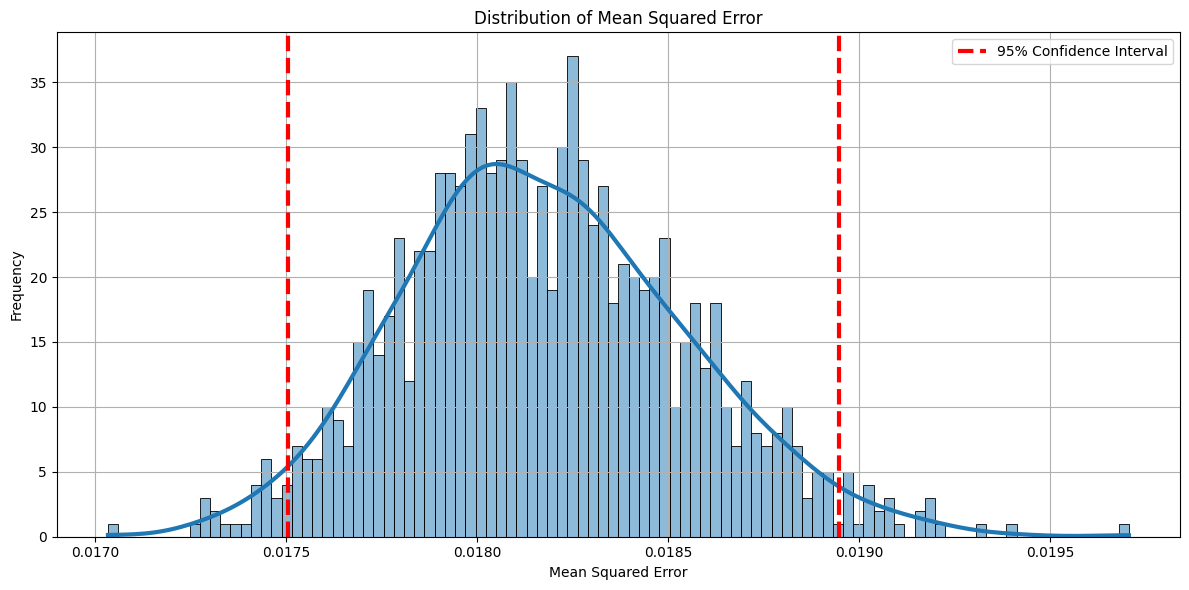

In [15]:
_, ax = plt.subplots(1, figsize=(12, 6))

# Plot MSE values and confidence interval
sns.histplot(
    mse_scores,
    bins=100,
    kde=True,
    line_kws={"linewidth": 3},
    ax=ax,
)
ax.axvline(
    x=mse_lower_percentile,
    color="red",
    linestyle="--",
    linewidth=3,
    label=f"{confidence_level*100:.0f}% Confidence Interval",
)
ax.axvline(x=mse_upper_percentile, color="red", linestyle="--", linewidth=3)

ax.set_title("Distribution of Mean Squared Error")
ax.set_xlabel("Mean Squared Error")
ax.set_ylabel("Frequency")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

### Conclusion

In accordance with the assignment instructions, our analysis involved several key steps. We initiated the process by downloading the dataset and eliminating the initial five columns, which are `state`, `county`, `community`, `communityname`, `fold` and require specific action.

Subsequently, we conducted a thorough analysis of the dataset, revealing the presence of missing data in several columns. To address this, we applied a data imputation strategy by replacing missing values with the mean of all values within the corresponding feature.

With the data prepared, we proceeded to implement two essential techniques for model evaluation: k-fold cross-validation and leave-one-out cross-validation. The latter is essentially an extreme case of k-fold cross-validation where k is equal to the number of samples. These methods helped us assess the performance and generalization capabilities of our models.

Once cross-validation was successfully implemented, we delved into the process of forward feature selection. This technique allowed us to identify the n-best columns for our dataset by evaluating the mean squared error of linear regression models. Ultimately, this method provided us with a selection of `31` optimal attributes. These attributes are: `PctIlleg`, `TotalPctDiv`, `HousVacant`, `racePctWhite`, `PctWorkMom`, `PctKids2Par`, `pctUrban`, `NumStreet`, `numbUrban`, `PctPolicWhite`, `MalePctDivorce`, `MedOwnCostPctIncNoMtg`, `PctEmplManu`, `PctSameCity85`, `pctWRetire`, `MedRentPctHousInc`, `PctPopUnderPov`, `pctWInvInc`, `pctWSocSec`, `LemasPctOfficDrugUn`, `HispPerCap`, `RacialMatchCommPol`, `NumIlleg`, `RentLowQ`, `MedRent`, `PctPersOwnOccup`, `AsianPerCap`, `PctHousOwnOcc`, `medIncome`, `OtherPerCap`, and `PctEmploy`.

Having identified these top attributes, we trained a new linear regression model and evaluated its performance on the test data. To provide a meaningful comparison, we contrasted these results with those obtained without the application of forward feature selection. It's important to note that the randomness in the training and test set splits and the inherent variability of cross-validation results could lead to different numbers in each iteration.

The results of our analysis are presented below.

```json
Mean Absolute Error: 0.09414514722458009
Mean Squared Error: 0.017820165212195822
R-squared: 0.6279384627907283
```

Following the model assessment, we conducted a comprehensive analysis through various plots. These visualizations confirmed that the model's residuals were remarkably centered around zero. However, it is worth noting that numerous potential enhancements can be explored in future iterations.

Finally, we applied the Bootstrap method to understand the distribution of mean square error. Through `1000` iterations, we observed that the error followed a normal distribution with a mean of approximately `0.01825`. Furthermore, we derived confidence intervals, which are crucial in quantifying uncertainty and providing valuable insights into our analysis.
